In [1]:
!trash-empty

In [2]:
from radam import RAdam, PlainRAdam, AdamW
from am_softmax import AMSoftmaxLoss, AngleSimpleLinear

In [3]:
import os
import gc
import numpy as np 
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats.stats import pearsonr

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms as T
import torch.nn.functional as F

from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import  EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

torch.cuda.empty_cache()

In [4]:
config = {
    'SEED': 42,
    'CLASSES': 1108,
    'PATH_DATA': '/home/tienen/kaggle_dataset_drugs/',
    'DEVICE': 'cuda',
    'BATCH_SIZE': 8,
    'VAL_SIZE': 0.05,
}

In [5]:
def seed_torch(seed=42):
    import random; import os
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(config['SEED'])

---

In [6]:
df = pd.read_csv(config['PATH_DATA']+'/train.csv')
df_test = pd.read_csv(config['PATH_DATA']+'/test.csv')

df['category'] = df['experiment'].apply(lambda x: x.split('-')[0])
df_test['category'] = df_test['experiment'].apply(lambda x: x.split('-')[0])

In [7]:
df['sirna'].hist(bins=1108, figsize=[7,3]);

In [8]:
output_df = []

categories = df['category'].unique()
for category in categories:
    category_df = df[df['category'] == category]
    cat_test_df = df_test[df_test['category'] == category].copy()
    output_df.append(cat_test_df)
output_df = pd.concat(output_df)

In [9]:
checkpoint_1 = np.load('predictions/EfficientNet_b2_AMSLoss_RAdam_each_exps_best_epoch_by_loss_lr1e-4.npy')
checkpoint_2 = np.load('predictions/DenseNet201_AMSLoss_each_exps_best_epoch_by_loss_lr1e-4.npy')
checkpoint_3 = np.load('predictions/SeResNext_each_exps_best_epoch_by_loss_lr1e-4.npy')
checkpoint_4 = np.load('predictions/EffNet-b5_AMSLoss_each_exps_best_epoch_by_loss_lr1e-4.npy')
checkpoint_5 = np.load('predictions/EffNet-b5_AMSLoss-freezing_each_exps_best_epoch_by_loss_lr1e-4.npy')
checkpoint_6 = np.load('predictions/DenseNet201_2sites_sum_each_exps_best_epoch_by_loss_lr1e-4.npy')
checkpoint_7 = np.load('predictions/DenseNet201-FP16_each_exps_best_epoch_by_loss_lr1e-4.npy')
checkpoint_8 = np.load('predictions/DenseNet201-FL_each_exps_best_epoch_by_loss_lr1e-4.npy')

all_checkpoints = [checkpoint_1, checkpoint_2, checkpoint_3, checkpoint_4, checkpoint_5, checkpoint_6, checkpoint_7, checkpoint_8]

---

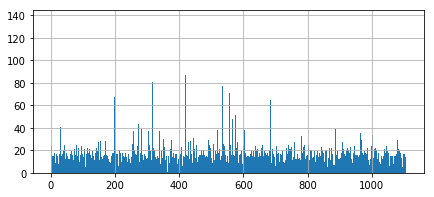

In [12]:
output_df['sirna_by_checkpoint'] = np.argmax(checkpoint_1, axis=1).astype(int)
output_df['sirna_by_checkpoint'].hist(bins=1108, figsize=[7,3]);

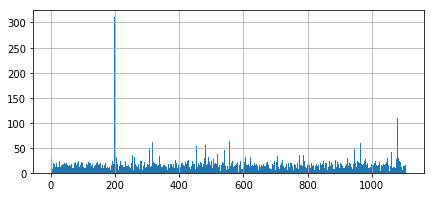

In [13]:
output_df['sirna_by_checkpoint'] = np.argmax(checkpoint_2, axis=1).astype(int)
output_df['sirna_by_checkpoint'].hist(bins=1108, figsize=[7,3]);

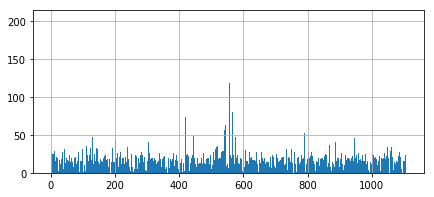

In [14]:
output_df['sirna_by_checkpoint'] = np.argmax(checkpoint_3, axis=1).astype(int)
output_df['sirna_by_checkpoint'].hist(bins=1108, figsize=[7,3]);

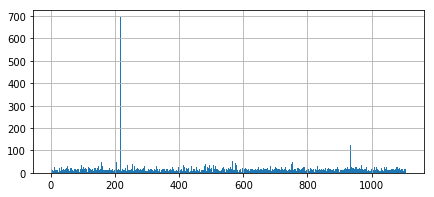

In [15]:
output_df['sirna_by_checkpoint'] = np.argmax(checkpoint_4, axis=1).astype(int)
output_df['sirna_by_checkpoint'].hist(bins=1108, figsize=[7,3]);

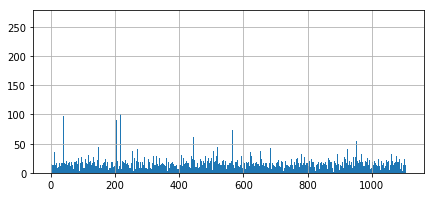

In [16]:
output_df['sirna_by_checkpoint'] = np.argmax(checkpoint_5, axis=1).astype(int)
output_df['sirna_by_checkpoint'].hist(bins=1108, figsize=[7,3]);

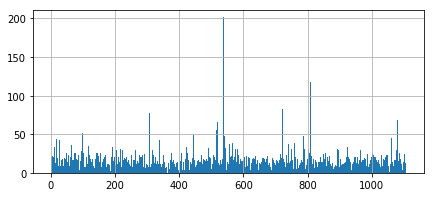

In [17]:
output_df['sirna_by_checkpoint'] = np.argmax(checkpoint_6, axis=1).astype(int)
output_df['sirna_by_checkpoint'].hist(bins=1108, figsize=[7,3]);

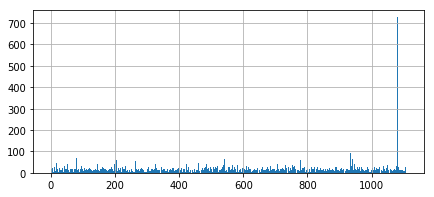

In [18]:
output_df['sirna_by_checkpoint'] = np.argmax(checkpoint_7, axis=1).astype(int)
output_df['sirna_by_checkpoint'].hist(bins=1108, figsize=[7,3]);

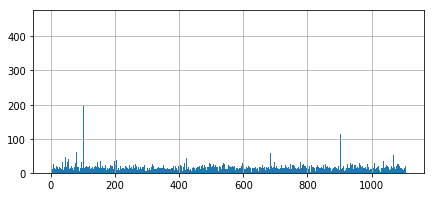

In [19]:
output_df['sirna_by_checkpoint'] = np.argmax(checkpoint_8, axis=1).astype(int)
output_df['sirna_by_checkpoint'].hist(bins=1108, figsize=[7,3]);

## BLENDING

## Use plates leak

In [18]:
blend_preds = (checkpoint_1 + checkpoint_2 + checkpoint_3 + checkpoint_4) / 4

output_df['sirna'] = np.argmax(blend_preds, axis=1).astype(int)
submission = output_df[['id_code', 'sirna']]
submission.to_csv('blend_submits/blend_checkpoints_1_2_3_4_mean.csv',
                  index=False, columns=['id_code','sirna'])

print(len(submission.sirna.unique()))

for ch_2 in all_checkpoints:
    print(pearsonr(submission.sirna, np.argmax(ch_2, axis=1)))

submission.head()

1107
(0.6940112529843953, 0.0)
(0.6845610745455902, 0.0)
(0.6372141120418947, 0.0)
(0.6261932489535218, 0.0)
(0.5748879581873831, 0.0)
(0.5375588255879685, 0.0)
(0.5269840385947133, 0.0)
(0.5840606386706646, 0.0)


,id_code,sirna
0,HEPG2-08_1_B03,855
1,HEPG2-08_1_B04,710
2,HEPG2-08_1_B05,836
3,HEPG2-08_1_B06,249
4,HEPG2-08_1_B07,39


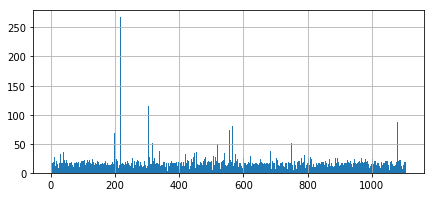

In [19]:
submission['sirna'].hist(bins=1108, figsize=[7,3]);

In [20]:
plate_groups = np.zeros((1108,4), int)
for sirna in range(1108):
    grp = df.loc[df.sirna==sirna,:].plate.value_counts().index.values
    assert len(grp) == 3
    plate_groups[sirna,0:3] = grp
    plate_groups[sirna,3] = 10 - grp.sum()
    
print(plate_groups[:10,:])

[[4 2 3 1]
 [1 3 4 2]
 [2 4 1 3]
 [1 3 4 2]
 [3 1 2 4]
 [1 3 4 2]
 [1 3 4 2]
 [2 4 1 3]
 [1 3 4 2]
 [4 2 3 1]]


In [22]:
all_test_exp = output_df.experiment.unique()

group_plate_probs = np.zeros((len(all_test_exp),4))
for idx in range(len(all_test_exp)):
    preds = output_df.loc[output_df.experiment == all_test_exp[idx],'sirna'].values
    pp_mult = np.zeros((len(preds),1108))
    pp_mult[range(len(preds)),preds] = 1
    
    sub_test = output_df.loc[output_df.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    
    for j in range(4):
        mask = np.repeat(plate_groups[np.newaxis, :, j], len(pp_mult), axis=0) == \
               np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
        
        group_plate_probs[idx,j] = np.array(pp_mult)[mask].sum()/len(pp_mult)

In [23]:
exp_to_group = group_plate_probs.argmax(1)
print(exp_to_group)

[3 1 0 0 0 0 2 2 3 0 0 3 1 0 0 0 2 3]


In [24]:
# this is the function that sets 75% of the sirnas to zero according to the selected assignment

def select_plate_group(pp_mult, idx):
    sub_test = output_df.loc[output_df.experiment == all_test_exp[idx],:]
    assert len(pp_mult) == len(sub_test)
    mask = np.repeat(plate_groups[np.newaxis, :, exp_to_group[idx]], len(pp_mult), axis=0) != \
           np.repeat(sub_test.plate.values[:, np.newaxis], 1108, axis=1)
    pp_mult[mask] = 0
    return pp_mult

In [25]:
sub = submission.copy()

for idx in range(len(all_test_exp)):
    indices = (output_df.experiment == all_test_exp[idx])
    preds = blend_preds[indices, :].copy()
    
    preds = select_plate_group(preds, idx)
    sub.loc[indices,'sirna'] = preds.argmax(1)

In [26]:
sub.to_csv('blend_submits/checkpoints_1_2_3_4_mean_PL.csv',
           index=False, columns=['id_code','sirna'])

In [27]:
print((sub.sirna == submission.sirna).mean())

0.7850932301351963


In [28]:
len(submission.sirna.unique()), len(sub.sirna.unique())

(1107, 1108)

In [29]:
sub.head()

,id_code,sirna
0,HEPG2-08_1_B03,855
1,HEPG2-08_1_B04,710
2,HEPG2-08_1_B05,836
3,HEPG2-08_1_B06,249
4,HEPG2-08_1_B07,270


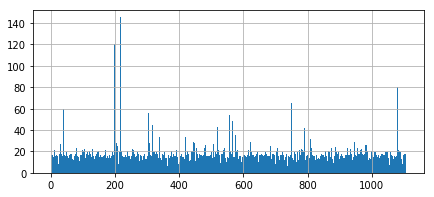

In [30]:
sub['sirna'].hist(bins=1108, figsize=[7,3]);